All code based on:
https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3

In [2]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

# data
data_path = 'data/'
words = open(data_path + 'names.txt','r').read().splitlines()

print(f'Number of words in dataset: {len(words)}')

Number of words in dataset: 32033


In [4]:
# Char to index map:
chars = list(set(''.join(words)))
chars = ['.'] + chars
char_index_map = {s:i for i, s in enumerate(chars)}

print(char_index_map)

{'.': 0, 'u': 1, 'v': 2, 'y': 3, 'r': 4, 'c': 5, 'h': 6, 'x': 7, 's': 8, 'g': 9, 'k': 10, 'd': 11, 'w': 12, 'q': 13, 'p': 14, 'z': 15, 'e': 16, 'o': 17, 'l': 18, 'm': 19, 'i': 20, 'f': 21, 't': 22, 'b': 23, 'n': 24, 'j': 25, 'a': 26}


In [63]:
# Training dataset

def get_training_data(words, block_size = 3):
    x, y = [], []
    for w in words:
        context = [0 for i in range(block_size)]
        for ch in w + '.':
            idx = char_index_map[ch]
            x.append(context)
            y.append(idx)
            context = context[1:] + [idx]

    return torch.tensor(x), torch.tensor(y)

block_size = 3
X, Y = get_training_data(words, char_index_map, block_size)

In [64]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))

block_size = 3
Xtr, Ytr = get_training_data(words[:n1], block_size)
Xv, Yv = get_training_data(words[n1:], block_size)

In [66]:
Xtr.shape

torch.Size([182625, 3])

In [67]:
Xv.shape

torch.Size([45521, 3])

In [15]:
# Embedding:
# 27 characters, to be embedded into a d-dimensional space, with d<<27
# choose d = 2
emb_dim = 2
C = torch.randn((27, emb_dim))

In [17]:
# Each element of Y is a character, which is taken to a 2d vector under the action of C
C[Y[:3]]

tensor([[-2.5754,  0.0198],
        [ 0.0710, -0.1281],
        [ 0.0710, -0.1281]])

In [19]:
# Each element of X is a list of three characters, which is taken to a list of three 2d vectors under the action of C
C[X[:3]]

tensor([[[-0.1036, -0.9124],
         [-0.1036, -0.9124],
         [-0.1036, -0.9124]],

        [[-0.1036, -0.9124],
         [-0.1036, -0.9124],
         [-2.5754,  0.0198]],

        [[-0.1036, -0.9124],
         [-2.5754,  0.0198],
         [ 0.0710, -0.1281]]])

In [22]:
C[X].shape

torch.Size([228146, 3, 2])

In [23]:
torch.cat(torch.unbind(C[X],1),1).shape

torch.Size([228146, 6])

In [25]:
# More memory efficient
C[X].view(C[X].shape[0], C[X].shape[1]*C[X].shape[2]).shape

torch.Size([228146, 6])

In [68]:
# Embedding is size (n_samples, block_length, emb_dim) = (, 3, 2)
g = torch.Generator().manual_seed(2147483647)

emb_dim = 2
C = torch.randn((27, emb_dim), generator = g)
# Layer 1
layer_out_size = 100 
W1 = torch.randn((block_size*emb_dim , layer_out_size), generator = g)
b1 = torch.randn(layer_out_size, generator = g)
# Layer 2
W2 = torch.randn((layer_out_size, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True


"""emb = C[X]
h = torch.tanh( emb.view(emb.shape[0], block_size*emb_dim) @ W1 + b1 )
# output is a tensor (nsamples, 27)
logits = h @ W2 + b2
#logcounts = logits.exp()
#prob = logcounts/logcounts.sum(1, keepdim = True)
# Loss
# obtain probaility, take log and sum, then minus
#nll = - prob[torch.arange(Y.shape[0]), Y].log().mean()
#loss = nll.item()
loss = F.cross_entropy(logits, Y)

loss"""

'emb = C[X]\nh = torch.tanh( emb.view(emb.shape[0], block_size*emb_dim) @ W1 + b1 )\n# output is a tensor (nsamples, 27)\nlogits = h @ W2 + b2\n#logcounts = logits.exp()\n#prob = logcounts/logcounts.sum(1, keepdim = True)\n# Loss\n# obtain probaility, take log and sum, then minus\n#nll = - prob[torch.arange(Y.shape[0]), Y].log().mean()\n#loss = nll.item()\nloss = F.cross_entropy(logits, Y)\n\nloss'

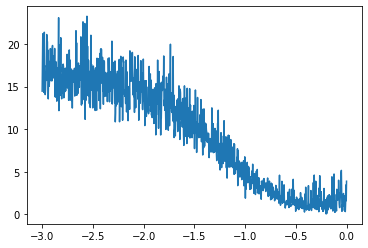

In [69]:
def find_lr(X, Y, episodes = 10, minibatch = 32): # X here should be the validation set

    number_cases = 1000
    lrs_exponent = torch.linspace(-3, 0, number_cases)
    lrs = 10**lrs_exponent

    results = []

    for i in range(number_cases):

        emb_dim = 2
        C = torch.randn((27, emb_dim), generator = g)
        # Layer 1
        layer_out_size = 100 
        W1 = torch.randn((block_size*emb_dim , layer_out_size), generator = g)
        b1 = torch.randn(layer_out_size, generator = g)
        # Layer 2
        W2 = torch.randn((layer_out_size, 27), generator = g)
        b2 = torch.randn(27, generator = g)

        parameters = [C, W1, b1, W2, b2]
        for p in parameters:
            p.requires_grad = True
    
        # Run training only on random minibatches. Doesnt use the exact gradient. Only the one computed from the minibatch
        ix = torch.randint(0, X.shape[0], (32,))
        for _ in range(episodes):
            # Forward
            emb = C[X[ix]] # emb = C[X]
            h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Y[ix]) # loss = F.cross_entropy(logits, Y)

            # Is this necessary?
            for p in parameters:
                p.grad = None

            # Backward
            loss.backward()

            # update
            for p in parameters:
                p.data += - lrs[i] * p.grad

        results.append(loss.item())


    return lrs_exponent, results

lre, r = find_lr(Xv, Yv, episodes = 10, minibatch = 32)

plt.plot(lre, r)
plt.show()

In [70]:
# Embedding is size (n_samples, block_length, emb_dim) = (, 3, 2)
g = torch.Generator().manual_seed(2147483647)

emb_dim = 2
C = torch.randn((27, emb_dim), generator = g)
# Layer 1
layer_out_size = 100 
W1 = torch.randn((block_size*emb_dim , layer_out_size), generator = g)
b1 = torch.randn(layer_out_size, generator = g)
# Layer 2
W2 = torch.randn((layer_out_size, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

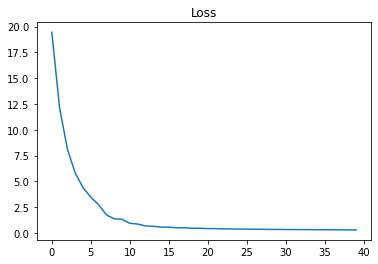

In [71]:
def train(X, Y, episodes = 10, lr=0.1, minibatch = 32):
    history = []

    # Run training only on random minibatches. Doesnt use the exact gradient. Only the one computed from the minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    for _ in range(episodes):
        # Forward
        emb = C[X[ix]] # emb = C[X]
        h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix]) # loss = F.cross_entropy(logits, Y)

        #print(f'Loss: {loss.item()}')
        history.append(loss)

        # Is this necessary?
        for p in parameters:
            p.grad = None

        # Backward
        loss.backward()

        # update
        for p in parameters:
            p.data += - lr * p.grad

    return history

history = train(Xtr, Ytr, episodes= 40, lr=0.3)

plt.plot(history)
plt.title('Loss')
plt.show()

In [84]:
def predict(context_init):
    context = [c for c in context_init]
    string = ''.join(context)
    done = False

    while not done:
        emb = C[[char_index_map[c] for c in context]] # emb = C[X]
        h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )
        logits = h @ W2 + b2
        logcounts = logits.exp()
        p = logcounts / logcounts.sum(1, keepdims = True)

        # Sample from proba
        random_idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        character = chars[random_idx]
        string = string + character
        context = context[1:] + [character]

        print(string)

        if character == '.':
            done = True
    

    return string

predict('..p')

..pa
..par
..paro
..paron
..paronh
..paronhk
..paronhk.


'..paronhk.'